## PART 1 - Key Facial Points Detection
Creating a deep learning model based on Convolutional Neural Networks and Residual Blocks to predict facial key-points.

In [71]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [72]:
# load in key facial data points
keyfacial_df = pd.read_csv("data.csv")
keyfacial_df.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


***

<br>

### Exploratory Analysis and Data Cleaning


In [73]:
# Obtain relevant information about dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [74]:
# Checking for null values
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [75]:
# Size of datafram
keyfacial_df['Image'].shape

(2140,)

In [76]:
# Reshaping data --> since values for the image are given as space seperated string, the values need to be reseparated using a space: ' '.
# The data is then converted into a 1d numpy array which then is reshaped into a 2d array with a size of 96 by 96 pixels (the dimensions of the image)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96,96))


In [77]:
# Confirming the dimensions
keyfacial_df['Image'][0].shape

(96, 96)

In [78]:
# Looking at the statistical summary of the dataframe
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


***

<br>

### Preforming Image Visualization

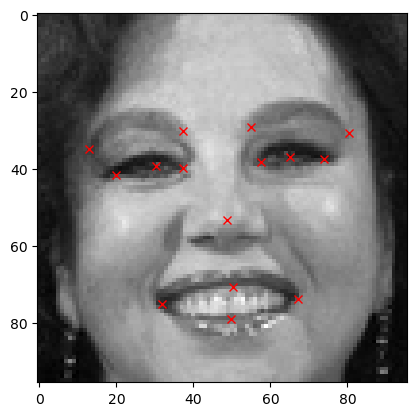

In [79]:
# Plotting a random image from the dataset along its corresponding facial keypoints

# Selecting a random row
i = np.random.randint(1, len(keyfacial_df))
# Plotting row i's associated image
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
# Looping through i by steps of 2 to map the x and y coordinates of each facial keypoint
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

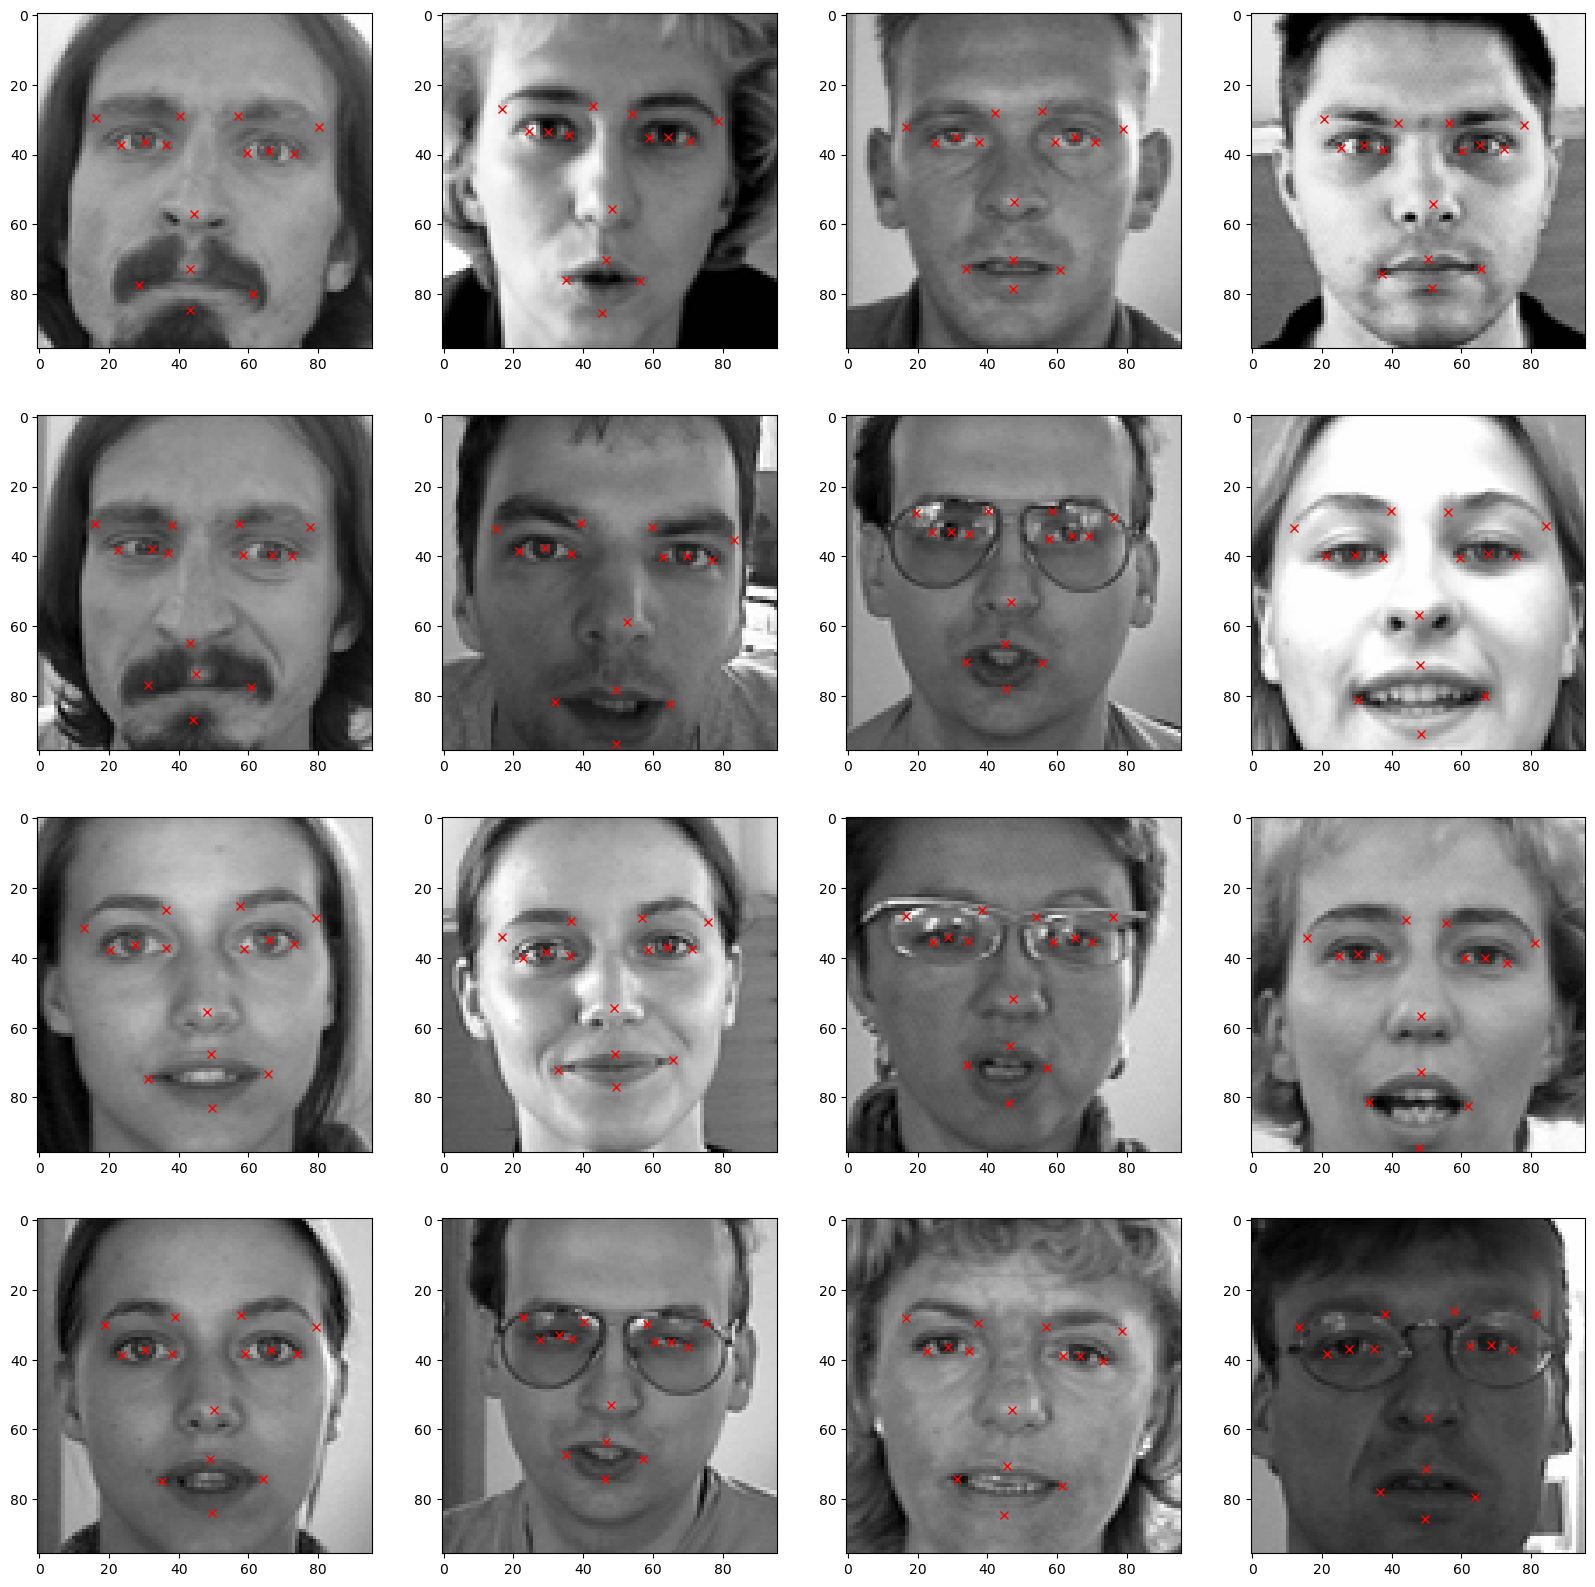

In [80]:
# Plotting more images in a 4x4 grid

fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

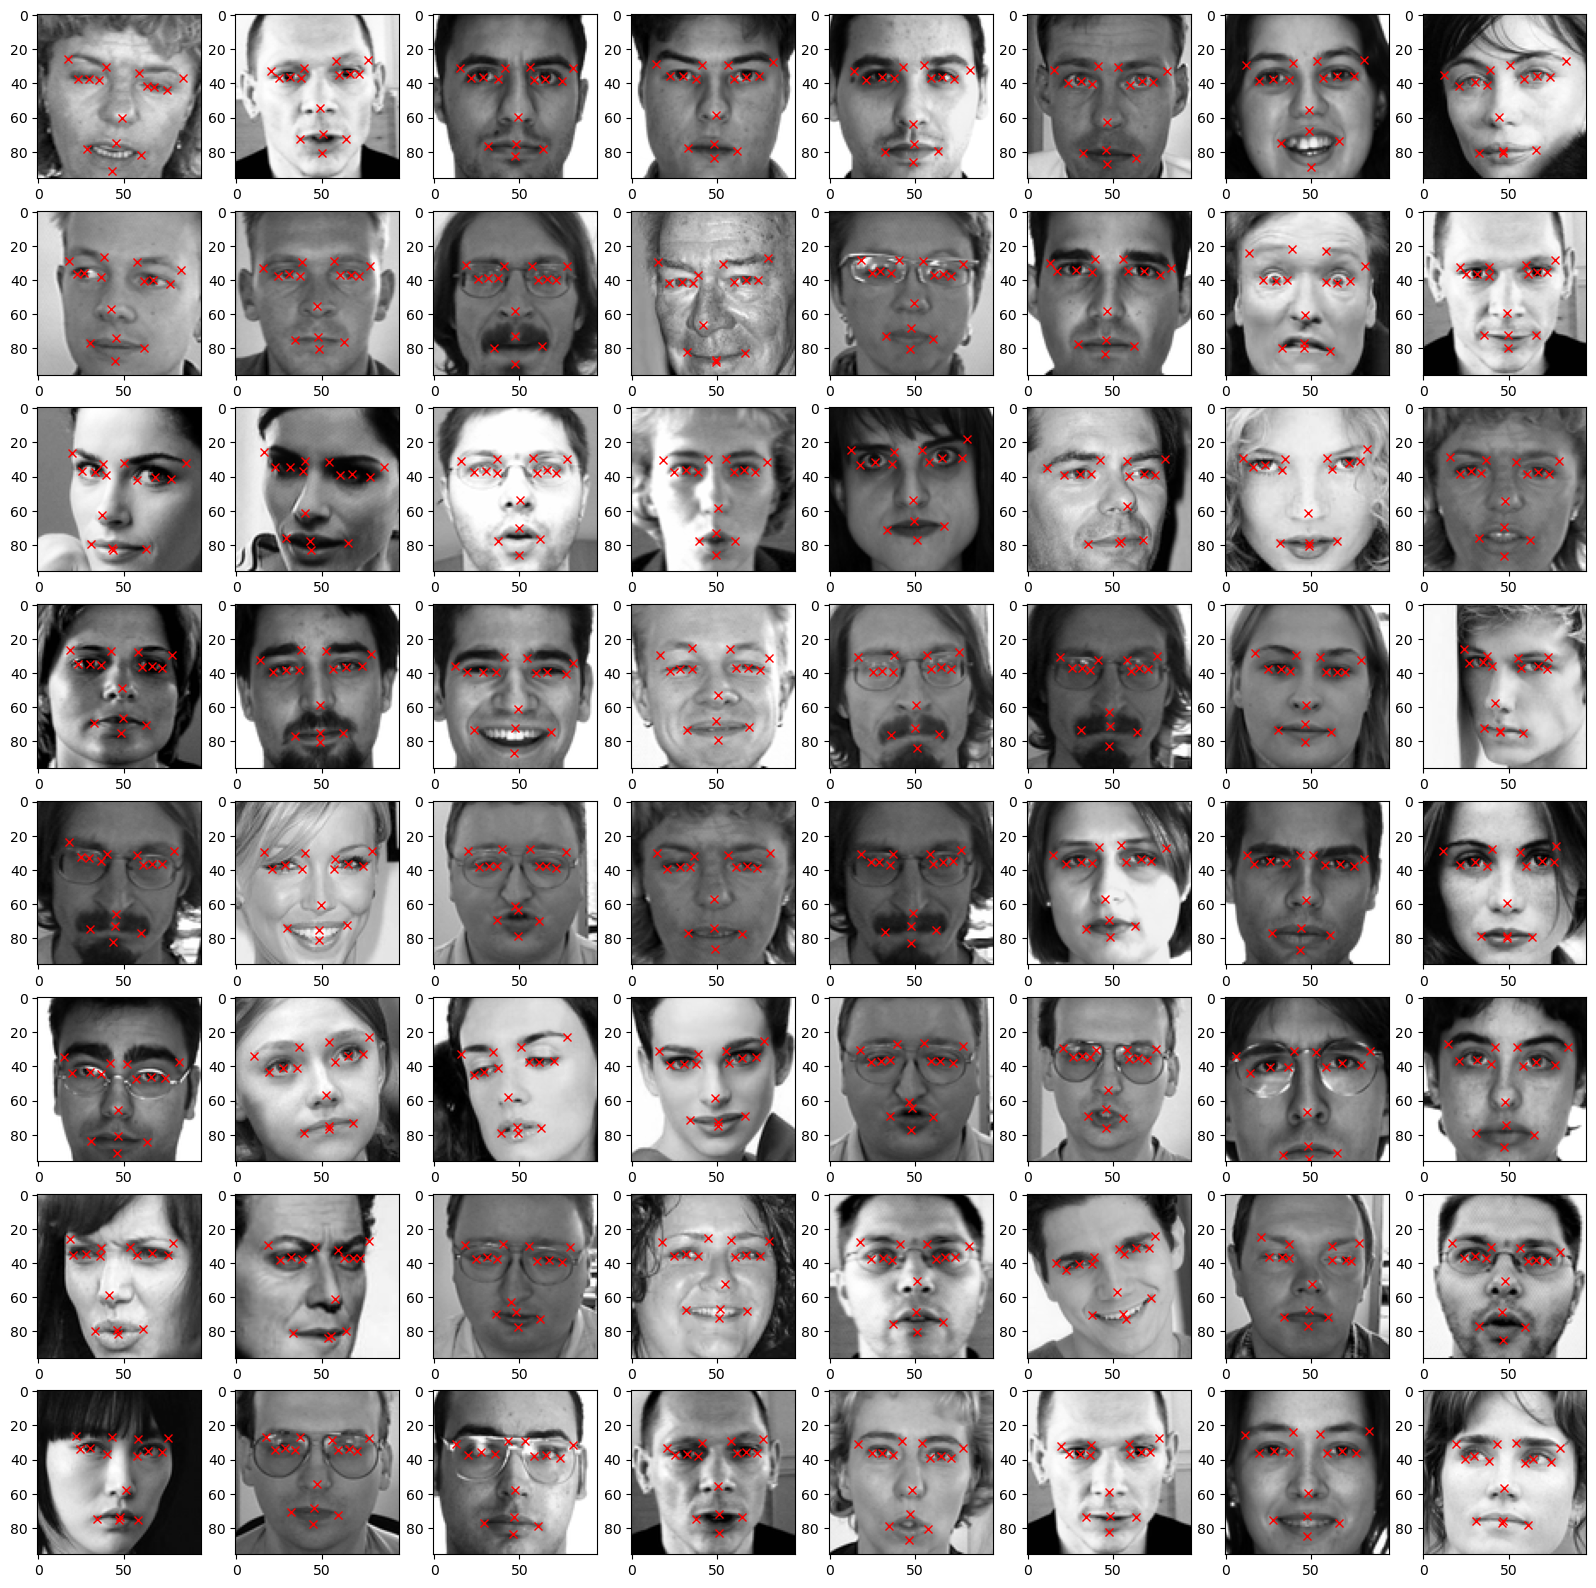

In [81]:
# Sanity check on the data

fig = plt.figure(figsize=(20, 20))

for j in range(64):
    i = np.random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, j + 1)
    image = plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
    for k in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][k-1], keyfacial_df.loc[i][k], 'rx')

***

<br>

### Preform Image Augmentation

In [82]:
# Creating a copy of the dataframe 
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

# The copy will include a varied version of the original's images to improve the model's generalibility

In [83]:
# Obtaining the columns in the dataframe besides the image portion
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [84]:
# Horizontally flipping the images (mirroring)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

# Adjusting the x coordinates to the mirrored images (y coordinates stay the same)
for i in range(len(columns)):
    if i%2 == 0:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x)) 
        # Flipping the coordinate is achieved by subtracting the original number by the width of the image i.e. 96 pixels.

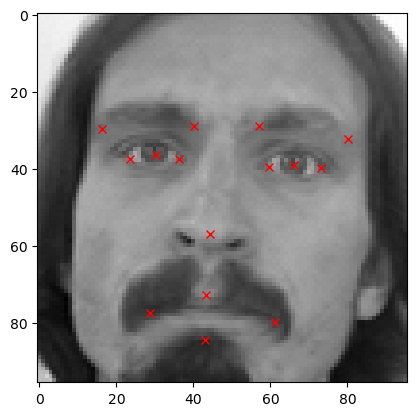

In [85]:
# Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

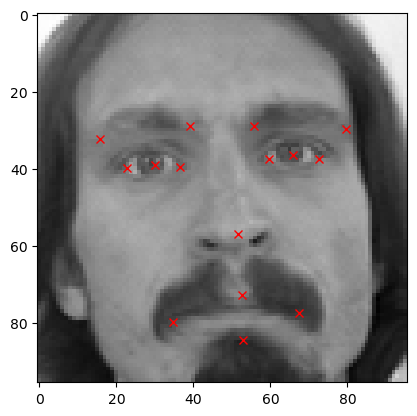

In [86]:
# Flipping image
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [87]:
# Concatenate the original dataframe with the flipped dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

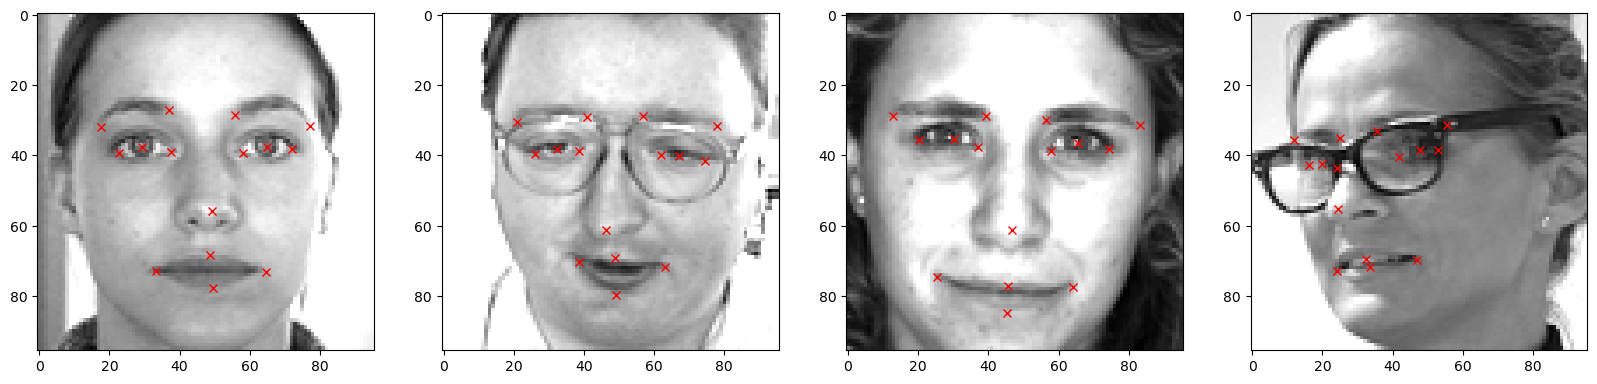

In [88]:
# Increasing the brightness of random images 
#This is achieved by multiplying pixel values between 1.5 and 2, and clipping the value between 0 and 255

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.clip(np.random.uniform(1.5, 2) * x, 0.0, 255.0))

# Confirming changes
fig = plt.figure(figsize=(20, 20))
for i in range(4):
    j = np.random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(1, 4, i + 1)
    image = plt.imshow(keyfacial_df_copy['Image'][j], cmap = 'gray')
    for k in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[j][k-1], keyfacial_df_copy.loc[j][k], 'rx')


In [89]:
# Adding the new images
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

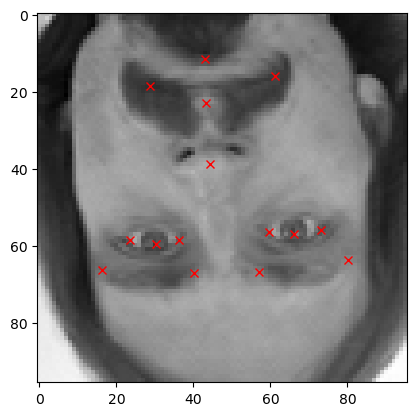

In [90]:
# Vertically flipping the images 
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))

# Adjusting the y coordinates to the flipped images (x coordinates stay the same)
for i in range(len(columns)):
    if i%2 == 1:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x)) 
        # Flipping the coordinate is achieved by subtracting the original number by the heighth of the image i.e. 96 pixels.

plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [91]:
# Adding changes
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(8560, 31)

***

<br>

### Preform Data Normalization and Training Data Preparation

In [92]:
# Input

# Storing all images from augmented_df into a list called img
img = augmented_df[:, 30]

# Normalizing the images
img = img/255. #dividing by 255 scales down the pixel values to a range between 0 and 1

# Creating an empy array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Converting the img list dimensions to match those of array X and adding the values
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)

# Converting type to float32
X = np.asarray(X).astype(np.float32)
X.shape 

(8560, 96, 96, 1)

In [93]:
# Output

# Obtaining the value of x and y coordinates
y = augmented_df[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [94]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

print(X_train.shape)
print(X_test.shape)

(5136, 96, 96, 1)
(3424, 96, 96, 1)


***

<br>